## Runs DE on different clusters. 
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/SE.rds"
sample_names = "preB,postB"
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/btwnClust_customGene/genes_donors_DE_minPct_00_pval0.1"

# Parameters
assay="RNA"
minPct = 0.00
logfcthresh = 0.25
top_de = 3
p_thresh=0.1
# test.use="wilcox"
# latent.vars = "NULL"

# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

to_gene_activity = TRUE
gene_type = "custom"
gene_file = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist/genes/genes.gtf"

In [2]:
source(utils_script)
dir.create(outdir)


Attaching SeuratObject



In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Lo

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
62328 features across 3683 samples within 2 assays 
Active assay: RNA (20010 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

In [7]:
annotations

GRanges object with 2765969 ranges and 24 metadata columns:
              seqnames        ranges strand |   source       type     score
                 <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]       chr1   29554-31109      + |   HAVANA gene              NA
        [2]       chr1   29554-31097      + |   HAVANA transcript        NA
        [3]       chr1   29554-30039      + |   HAVANA exon              NA
        [4]       chr1   30564-30667      + |   HAVANA exon              NA
        [5]       chr1   30976-31097      + |   HAVANA exon              NA
        ...        ...           ...    ... .      ...        ...       ...
  [2765965] KI270734.1 138483-138667      - |  ENSEMBL CDS               NA
  [2765966] KI270734.1 138480-138482      - |  ENSEMBL stop_codon        NA
  [2765967] KI270734.1 161689-161852      - |  ENSEMBL UTR               NA
  [2765968] KI270734.1 161587-161626      - |  ENSEMBL UTR               NA
  [2765969] KI270734.1 13808

In [10]:
"gene_biotype" %in% colnames(values(annotations))

[1] FALSE

In [11]:
colnames(values(annotations))

[1] "source"                   "type"                    
 [3] "score"                    "phase"                   
 [5] "gene_id"                  "gene_version"            
 [7] "gene_type"                "gene_name"               
 [9] "level"                    "hgnc_id"                 
[11] "tag"                      "havana_gene"             
[13] "transcript_id"            "transcript_version"      
[15] "transcript_type"          "transcript_name"         
[17] "transcript_support_level" "havana_transcript"       
[19] "exon_number"              "exon_id"                 
[21] "exon_version"             "protein_id"              
[23] "ccdsid"                   "ont"

In [12]:
if (to_gene_activity){
    library(rtracklayer)
    DefaultAssay(se) <- "ATAC"
    if (gene_type=="UCSC"){
        seqlevelsStyle(annotations) <- 'UCSC'
        genome(annotations) <- "hg38"
    }else{
        print("Custom genome")
        gffRangedData<-rtracklayer::import.gff(gene_file, format="gtf", genome="hg38")
        annotations<-as(gffRangedData, "GRanges")
        if (! "gene_biotype" %in% colnames(values(annotations)) ){
            values(annotations)$gene_biotype <- values(annotations)$gene_type
        }
    }

    # add the gene information to the object
    Annotation(se) <- annotations
    gene.activities <- GeneActivity(se)
    # compute nucleosome signal score per ce

    # add the gene activity matrix to the Seurat object as a new assay and normalize it
    se[['RNA']] <- CreateAssayObject(counts = gene.activities)
    se <- NormalizeData(
      object = se,
      assay = 'RNA',
      normalization.method = 'LogNormalize',
      scale.factor = median(se$nCount_RNA)
    )

    DefaultAssay(se) <- "RNA"
}

[1] "Custom genome"


Warning message in readGFFAsGRanges(resource, version = version, colnames = colnames, :
"cannot set the seqlengths or circularity flags on the GRanges object to
  return because the sequence names in the GTF or GFF file are in
  disagreement with the sequence names implied by the genome assembly
  (hg38) specified via the 'genome' argument"
Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



## Run DE for  cluster vs all others 

In [13]:
btwnClust.outdir <- file.path(outdir, "btwnClust")
dir.create(btwnClust.outdir)


[1] "cluster 0"
                p_val avg_log2FC pct.1 pct.2    p_val_adj
ZEB2     1.327538e-56 -0.6414755 0.166 0.481 2.529225e-52
LYN      1.299085e-52 -0.6589562 0.123 0.404 2.475017e-48
PLEKHA2  1.528909e-51 -0.5185651 0.233 0.536 2.912878e-47
CMIP     5.830875e-49 -0.5196240 0.279 0.583 1.110898e-44
ARHGAP26 3.290274e-48 -0.6348338 0.506 0.738 6.268629e-44
PLCG2    2.607847e-47 -0.5683862 0.185 0.462 4.968470e-43
[1] "saved cluster 0"


Warning message:
"Only one identity present, the expression values will be not scaled"
The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 1"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
PLEKHG1 1.898287e-269  1.3382745 0.903 0.260 3.616615e-265
LYN     5.355227e-219  1.1568179 0.863 0.249 1.020278e-214
BLK     7.316014e-219  0.9739261 0.694 0.132 1.393847e-214
ZNF608  3.738813e-217  1.0123414 0.769 0.187 7.123186e-213
CCR6    1.304210e-215  0.8252713 0.664 0.111 2.484780e-211
PNOC    1.994074e-193  0.6080873 0.475 0.049 3.799109e-189
[1] "saved cluster 1"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 2"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
MT-CO2  1.006014e-46  0.5890149     1     1 1.916659e-42
MT-ATP6 1.246731e-46  0.5924489     1     1 2.375272e-42
MT-CO1  4.215242e-46  0.5888705     1     1 8.030879e-42
MT-CO3  7.213282e-46  0.5887374     1     1 1.374274e-41
MT-ND2  3.390125e-45  0.5839710     1     1 6.458866e-41
MT-ATP8 4.830694e-45  0.5805744     1     1 9.203437e-41
[1] "saved cluster 2"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 3"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
CD8B   1.541024e-116  0.5544206 0.470 0.090 2.935958e-112
CD8A    5.174617e-94  0.6025151 0.575 0.172  9.858681e-90
LEF1    4.055813e-45  0.4869972 0.750 0.423  7.727135e-41
NELL2   4.828749e-35  0.4403721 0.683 0.406  9.199733e-31
BACH2   4.926156e-35  0.4287287 0.938 0.784  9.385313e-31
BCL11B  4.919793e-30  0.4024340 0.794 0.518  9.373190e-26
[1] "saved cluster 3"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 4"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
ATXN1  7.821631e-44  0.6222574 0.904 0.703 1.490177e-39
GALM   5.725719e-40  0.5163235 0.541 0.239 1.090864e-35
GLB1   4.809879e-37  0.6040723 0.561 0.275 9.163781e-33
VMP1   1.837310e-30  0.4660988 0.728 0.465 3.500443e-26
CTLA4  2.446266e-29  0.2709549 0.280 0.088 4.660626e-25
NIBAN1 1.122799e-27  0.5419056 0.552 0.305 2.139157e-23
[1] "saved cluster 4"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 5"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
TREM1    0.000000e+00  0.8925428 0.694 0.029  0.000000e+00
FPR1    6.134936e-307  0.8815971 0.675 0.032 1.168828e-302
FPR3    1.520094e-246  0.5573254 0.471 0.014 2.896083e-242
MAFB    6.007721e-231  0.4572721 0.420 0.011 1.144591e-226
TM4SF20 7.288001e-223  0.5194558 0.514 0.025 1.388510e-218
CLEC7A  7.010770e-213  0.5409342 0.506 0.027 1.335692e-208
[1] "saved cluster 5"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 6"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
GZMB   2.864699e-110  0.4951961 0.321 0.024 5.457825e-106
KRT74  6.792032e-105  0.5103425 0.361 0.034 1.294018e-100
NCR1    3.685568e-98  0.3501174 0.257 0.015  7.021744e-94
CCL18   1.265561e-93  0.4206040 0.329 0.031  2.411147e-89
SH2D1B  2.433797e-91  0.3308930 0.237 0.014  4.636870e-87
CST7    4.793235e-88  0.7425544 0.526 0.101  9.132072e-84
[1] "saved cluster 6"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 7"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
KRT74  5.668668e-93  0.5910987 0.402 0.039 1.079995e-88
CCL18  2.331231e-62  0.4640378 0.322 0.038 4.441462e-58
ZEB2   1.115000e-57  1.1804179 0.851 0.392 2.124298e-53
GZMB   1.487281e-52  0.3296516 0.276 0.032 2.833568e-48
PARD6G 2.977610e-50  0.5638496 0.460 0.099 5.672943e-46
PRKY   2.649854e-44  0.3093955 0.201 0.020 5.048503e-40
[1] "saved cluster 7"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 8"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
SARDH   2.634381e-39  0.3868888 0.671 0.187 5.019022e-35
MT-CO3  2.746267e-39 -1.0934226 1.000 1.000 5.232188e-35
MT-ND4L 2.832447e-39 -1.1019731 1.000 1.000 5.396378e-35
MT-ATP6 3.753324e-39 -1.0905545 1.000 1.000 7.150833e-35
MT-ND3  5.353724e-39 -1.0941367 1.000 1.000 1.019992e-34
MT-CO2  6.105701e-39 -1.0822577 1.000 1.000 1.163258e-34
[1] "saved cluster 8"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 9"
                p_val avg_log2FC pct.1 pct.2    p_val_adj
ZBTB16   5.492124e-45  1.1893702 0.885 0.473 1.046359e-40
FYCO1    2.209246e-38  0.7973254 0.708 0.251 4.209055e-34
RORC     7.009222e-33  0.3318629 0.308 0.053 1.335397e-28
GYG1     1.806214e-29  0.5526166 0.554 0.176 3.441198e-25
UEVLD    1.239797e-23  0.3950168 0.369 0.099 2.362061e-19
CDK5RAP1 3.874512e-23  0.4248127 0.392 0.113 7.381720e-19
[1] "saved cluster 9"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 10"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
GATA1  2.121985e-54  0.3196442 0.316 0.006 4.042806e-50
PRODH2 1.064762e-52  0.4107817 0.368 0.009 2.028584e-48
CSF2RB 2.713320e-50  0.7985827 0.684 0.035 5.169417e-46
HDC    1.552774e-39  1.0059972 0.789 0.060 2.958346e-35
IL1RL1 9.772496e-33  0.4762473 0.579 0.038 1.861856e-28
CACNG8 8.956802e-30  0.9017880 0.737 0.071 1.706450e-25
[1] "saved cluster 10"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



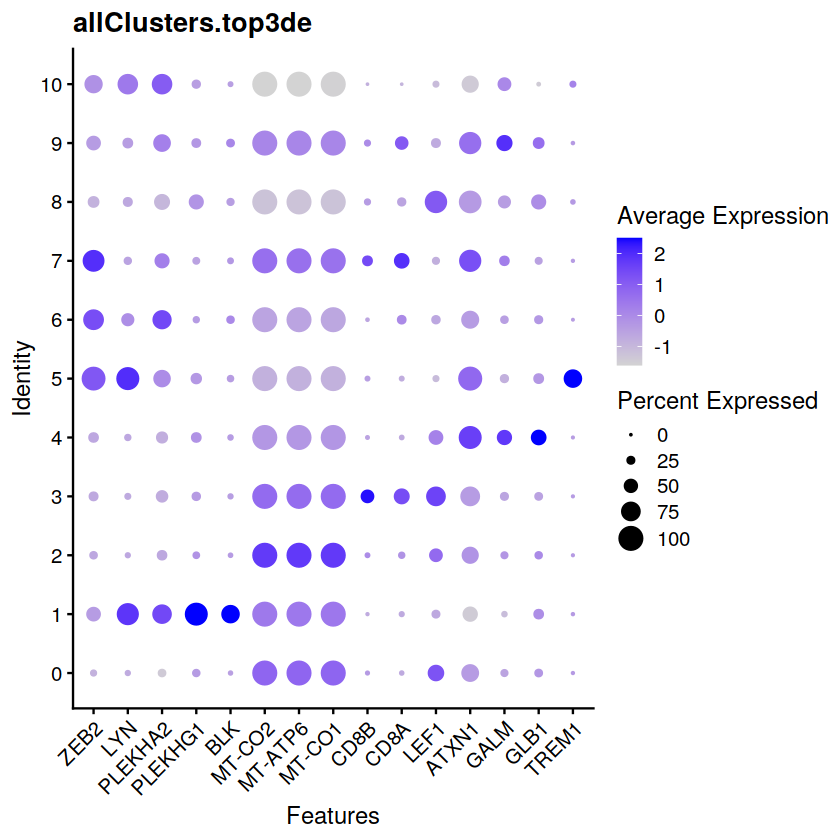

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



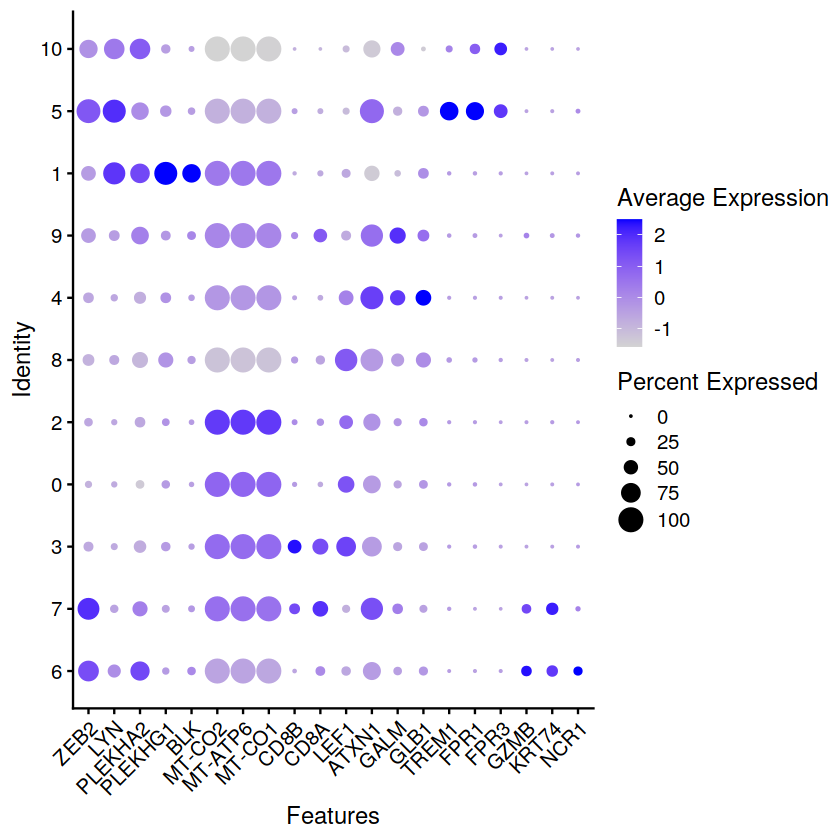

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



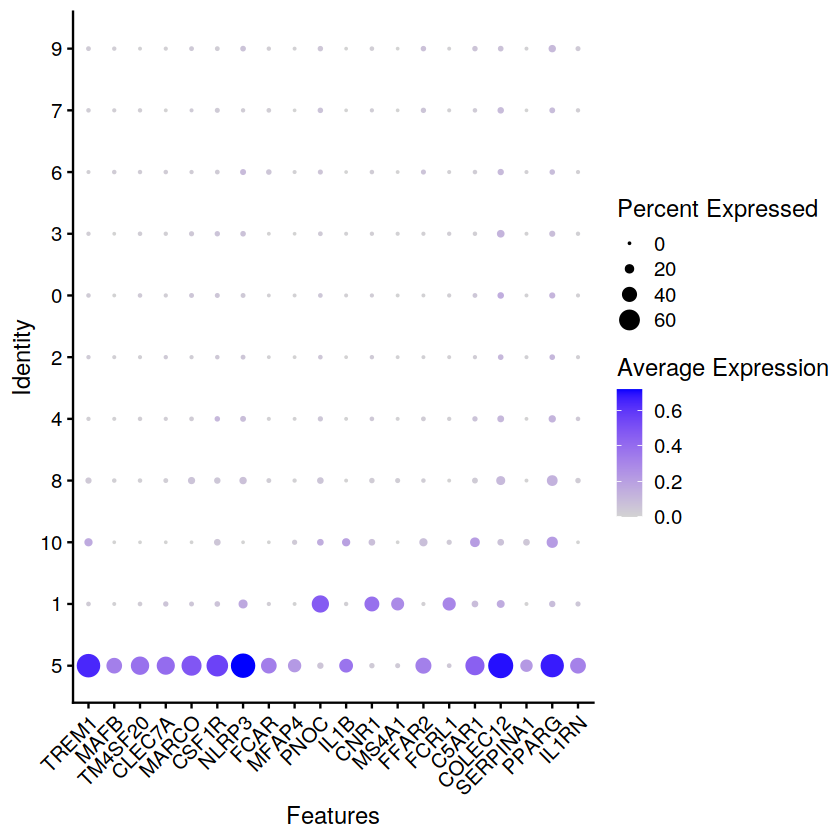

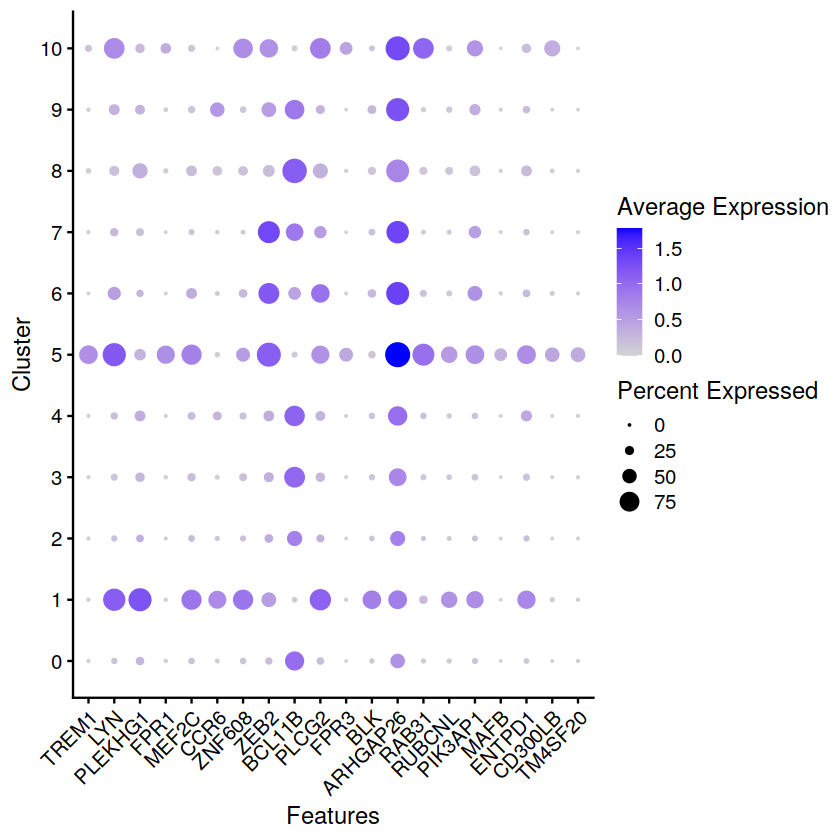

In [14]:
curr.outdir <- btwnClust.outdir

cluster.ids <- sort(unique(se$seurat_clusters))
Idents(se) <- se$seurat_clusters

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()
for (id1 in cluster.ids){ #or however many clusters you have
try({
    print(paste("cluster", id1))
    response <- FindMarkers(
                  object = se,
                  ident.1 = id1, #"CD4 Naive",
                  min.pct = minPct, logfc.threshold=logfcthresh,
                  test.use = 'wilcox', latent.vars = NULL
                )
    print(head(response))
    #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
    
    
    print(paste('saved cluster', id1))
    response <- response %>% dplyr::arrange(p_val)
    response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))    
    write.csv(response,
              file=file.path(curr.outdir, paste0("cluster",id1,".DE.csv")), quote=F)
    
    curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
    
    
    names.sig <- rownames(curr.sig)
    se.filt <- subset(se, seurat_clusters == id1)
    
    # Add to all pvals
    all.names.sig <- c(all.names.sig, head(names.sig, top_de))
    all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH
    de.plots(se.filt, names.sig, curr.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T)
    
})
}


all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, curr.outdir, curr.name="allClusters.top3de", max.size=15)

dot <- DotPlot(se, scale=T,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.top3de.png"))
ggsave(file.path(curr.outdir, "allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.png"))
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.png"))
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.pdf"))
dot

In [21]:
btwn_embeddings <- file.path(btwnClust.outdir, "embeddings")
dir.create(btwn_embeddings)


featplot <- function(name.sig, se, curr.outdir){
    if (name.sig %in% rownames(se)){
        feat <- FeaturePlot(se,  features=name.sig)

        ggsave(plot=feat,
               file=file.path(curr.outdir, paste0(name.sig,".embedFeat.top.png")))
    }else{print(paste0("not here: ", name.sig))}
    }
sapply(all.names.sig, FUN=featplot, se=se, curr.outdir=btwn_embeddings)

Warning message in dir.create(btwn_embeddings):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/btwnClust_customGene/genes_donors_DE_minPct_00_pval0.1/btwnClust/embeddings' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image


In [19]:
markers_f <- "/data/Mito_Trace/data/processed/pbmc_markers.txt"
markers <- read.csv(markers_f, header=F)[[1]]

In [23]:
markers

[1] "TCRA"    "CD56"    "CD161"   "NCR1"    "NCAM1"   "CEACAM8" "IGHM"   
 [8] "TCRA"    "IL7R"    "CCR7"    "CD14"    "LYZ"     "IL7R"    "S100A4" 
[15] "MS4A1"   "CD8A"    "FCGR3A"  "MS4A7"   "FCGR3A"  "GNLY"    "NKG7"   
[22] "FCER1A"  "CST3"    "PPBP"

In [22]:
sapply(markers, FUN=featplot, se=se, curr.outdir=btwn_embeddings)

[1] "not here: TCRA"
[1] "not here: CD56"
[1] "not here: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "not here: IGHM"
[1] "not here: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



TCRA 
                                                                                                                                                                                                                                                                                                                                                "not here: TCRA" 
                                                                                                                                                                                                                                                                                                                                                            CD56 
                                                                                                                                                                                                                                                                                                                                                "not here: CD56" 
                                                                                                                                                                                                                                                                                                                                                           CD161 
                                                                                                                                                                                                                                                                                                                                               "not here: CD161" 
                                                                                                                                                                                                                                                                                                                                                            NCR1 
   "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/btwnClust_customGene/genes_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/NCR1.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                                           NCAM1 
  "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/btwnClust_customGene/genes_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/NCAM1.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                                         CEACAM8 
"/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/btwnClust_customGene/genes_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/CEACAM8.embedFeat.top.png" 
                                                                                                    

In [ ]:
# name of the DF prediction can change, so extract the correct column name.
DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]



cowplot::plot_grid(ncol = 2, DimPlot(data.filt, group.by = "orig.ident") + NoAxes(),
    DimPlot(data.filt, group.by = DF.name) + NoAxes())

---

---

---

# Run cluster vs all for each donor

In [16]:
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")

In [17]:
btwnClust.sepDons.outdir <- file.path(outdir, "btwnClust_sepDons")
dir.create(btwnClust.sepDons.outdir)
curr.outdir <- btwnClust.sepDons.outdir

# Setup Idents to include the condition, clusters and donor
se$clust_donor <- as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
Idents(se) <- se$clust_donor
don.ids <- levels(se$donor)
cluster.ids <- sort(unique(se$seurat_clusters))

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

for (clust in cluster.ids){ #or however many clusters you have
    clust.names.sig <- c()
    print("cluster")
    print(clust)
    clust.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                              row.names=row.names(se))
    clust.outdir <- file.path(curr.outdir, paste0("clust", clust))
    dir.create(clust.outdir)
    for (don in don.ids){
        try({
            if (clust == "None" | don == "None"){
                print("clust or don is none")
                next
            }
            id1 = paste0(clust, "_", don)
            print("ID1")
            print(id1)
            response <- FindMarkers(
                          object = se,
                          ident.1 = id1, #"CD4 Naive",
                          min.pct = minPct,
                          test.use = 'wilcox', latent.vars = NULL
                        )
            
            #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
            response <- response %>% dplyr::arrange(p_val)
            response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))    
            print(head(response))
            write.csv(response,
                      file=file.path(clust.outdir, paste0("clust",clust,"donor", don, ".DE.csv")), quote=F)
            
            curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
            names.sig <- rownames(curr.sig)
            se.filt <- subset(se, idents = id1)
            de.plots(se.filt, names.sig, clust.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T)
            
            # Add to all pvals
            all.names.sig <- c(all.names.sig, head(names.sig, top_de))
            all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH
            clust.names.sig <- c(clust.names.sig, head(names.sig, top_de))
            clust.pvals[names.sig, don] <- curr.sig$p_val_adj_BH
        })
    }
    if (clust != "None"){
        se.filt <- subset(se, subset = seurat_clusters == clust & donor != "None")
        Idents(se.filt) <- se.filt$donor
        wrap.plot.over.all(se.filt, clust.outdir, clust.pvals, clust.names.sig, 
                           name=paste0("cluster",clust,"topDonorDE.split_donors"))
    }
}

wrap.plot.over.all(se, curr.outdir, all.pvals, all.names.sig, name="allClusters")
# all.names.sig <- unique(all.names.sig)
# de.plots(se, all.names.sig, curr.outdir, curr.name="combinedDonors.allClusters", max.size=15)

# dot <- DotPlot(se, scale=FALSE,
#                features = head(all.names.sig,20), 
#                cluster.idents=T) + RotatedAxis()
# dot
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.top3de.png"))
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.top3de.pdf"))

# ## b) averaged top p-values (only average ones that were DE)

# sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
# dot <- DotPlot(se, scale=F,
#                features = names(head(sig.all.ordered,20)), 
#                cluster.idents=T) + RotatedAxis()
# dot
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.pvalsOrdered.scaleF.png"))
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.pvalsOrdered.scaleF.pdf"))
# #de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



# all.pvals.nafill <- all.pvals
# all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

# sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
# dot <- DotPlot(se, scale=F,
#                features = head(names(sig.all.ordered),20), 
#                cluster.idents=F) + RotatedAxis() + ylab("Cluster")
    
# ggsave(file.path(btwnClust.sepDons.outdir,
#                  "combinedDonors.allClusters.ovalsOrderedNA.scaleF.png"))
# ggsave(file.path(btwnClust.sepDons.outdir,
#                  "combinedDonors.allClusters.ovalsOrderedNA.scaleF.pdf"))
# dot

[1] "cluster"
[1] "0"
[1] "ID1"
[1] "0_0"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ARHGAP26 3.838139e-11 -0.6247394 0.433 0.696 7.312423e-07 5.324200e-09
AXIN2    4.884587e-11  0.3765133 0.462 0.212 9.306115e-07 5.324200e-09
CACHD1   6.859478e-10  0.5474155 0.519 0.283 1.306868e-05 4.984554e-08
PITPNC1  1.487081e-08  0.4042484 0.846 0.631 2.833187e-04 8.104592e-07
PREX1    5.347519e-08 -0.4232922 0.212 0.468 1.018809e-03 2.331518e-06
BHLHE40  1.293921e-07 -0.3986195 0.058 0.293 2.465178e-03 4.701246e-06


Warning message:
"Only one identity present, the expression values will be not scaled"
Warning message in FeaturePlot(se.filt, features = names.sig):
"All cells have the same value (0) of SLC2A8."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of SLC2A8."
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "0_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MT-ND6 3.272982e-18  0.4532654     1     1 6.235685e-14 5.171311e-16
MT-CYB 6.908040e-17  0.4389624     1     1 1.316120e-12 5.457352e-15
MT-ND1 1.266179e-15  0.4138416     1     1 2.412323e-11 4.478671e-14
MT-ND4 2.062491e-15  0.4146607     1     1 3.929457e-11 4.478671e-14
MT-ND2 2.173700e-15  0.4058289     1     1 4.141333e-11 4.478671e-14
MT-CO2 2.618378e-15  0.4028947     1     1 4.988535e-11 4.478671e-14


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "0_2"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
CLDN1  6.128045e-07  0.2500089 0.261 0.071 0.01167515 0.0001831413
KRT73  6.743834e-07  0.3518819 0.283 0.085 0.01284835 0.0001831413
MT-ND6 1.099062e-06  0.4226774 1.000 1.000 0.02093934 0.0001831413
MT-ND2 1.344157e-06  0.4535018 1.000 1.000 0.02560887 0.0001831413
MT-ND1 1.944693e-06  0.4349740 1.000 1.000 0.03705029 0.0002100571
MT-CO1 2.312555e-06  0.4361469 1.000 1.000 0.04405880 0.0002100571


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "0_3"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ZEB2    5.876473e-29 -0.5528887 0.160 0.448 1.119586e-24 6.287826e-27
BACH2   2.546011e-27  0.4489638 0.891 0.793 4.850661e-23 1.362116e-25
PLEKHA2 6.034963e-26 -0.4420790 0.224 0.505 1.149781e-21 2.152470e-24
CMIP    2.646902e-24 -0.4372525 0.273 0.552 5.042878e-20 7.080463e-23
CXXC5   3.899079e-24 -0.3522179 0.062 0.290 7.428526e-20 7.208625e-23
IKZF1   4.042220e-24  0.4821916 0.811 0.717 7.701237e-20 7.208625e-23


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "1"
[1] "ID1"
[1] "1_0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CCR6   2.159464e-45  0.7267599 0.772 0.181 4.114211e-41 1.213619e-42
PNOC   4.282595e-38  0.5718292 0.533 0.104 8.159199e-34 1.203409e-35
CNR1   7.151785e-37  0.4670298 0.446 0.075 1.362558e-32 1.339768e-34
RUBCNL 3.269066e-35  0.7191140 0.685 0.187 6.228224e-31 4.593037e-33
ZNF608 3.278239e-34  0.8954245 0.783 0.263 6.245700e-30 3.684740e-32
MS4A1  6.922381e-34  0.3372102 0.359 0.053 1.318852e-29 6.483963e-32


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "1_1"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PNOC    1.012034e-25  0.5162507 0.523 0.107 1.928127e-21 5.890039e-23
PLEKHG1 6.336790e-25  0.9157201 0.908 0.349 1.207285e-20 1.844006e-22
ZNF608  2.939697e-20  0.6206665 0.769 0.268 5.600712e-16 5.703013e-18
BLK     7.523430e-19  0.7647694 0.646 0.211 1.433364e-14 8.825698e-17
FCRL1   7.582215e-19  0.2933776 0.338 0.061 1.444564e-14 8.825698e-17
CCR6    1.818707e-18  0.6790230 0.615 0.189 3.465000e-14 1.764145e-16


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "1_2"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
HLA-DQA1 1.019074e-52  0.4572139 0.451 0.059 1.941539e-48 5.533570e-50
BLK      5.082046e-49  0.8910729 0.784 0.202 9.682313e-45 1.379775e-46
PLEKHG1  5.800846e-47  1.0689777 0.922 0.343 1.105177e-42 1.049953e-44
MS4A1    1.219267e-43  0.3899468 0.382 0.051 2.322948e-39 1.655155e-41
ZNF608   1.598405e-42  0.9050342 0.814 0.261 3.045282e-38 1.735868e-40
SLC16A4  2.594564e-41  0.4045519 0.402 0.060 4.943163e-37 2.348080e-39


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "1_3"
                p_val avg_log2FC pct.1 pct.2     p_val_adj  p_val_adj_BH
PLEKHG1 4.341459e-137  1.2280739 0.915 0.311 8.271348e-133 2.335705e-134
LYN     8.061287e-116  1.0890329 0.877 0.298 1.535836e-111 2.168486e-113
CNR1    4.473940e-104  0.5555326 0.416 0.055 8.523751e-100 8.023266e-102
BLK     6.006112e-101  0.8891696 0.676 0.179  1.144284e-96  8.078221e-99
ZNF608   1.481433e-96  0.8926224 0.747 0.236  2.822425e-92  1.594022e-94
CCR6     4.680502e-94  0.7211870 0.638 0.158  8.917292e-90  4.196850e-92


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "2"
[1] "ID1"
[1] "2_0"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MT-ATP6 3.329279e-09  0.5558944     1     1 6.342942e-05 9.138196e-07
MT-ATP8 4.360022e-09  0.5415598     1     1 8.306713e-05 9.138196e-07
MT-CO2  5.129070e-09  0.5392557     1     1 9.771904e-05 9.138196e-07
MT-CO3  6.446699e-09  0.5417859     1     1 1.228225e-04 9.138196e-07
MT-ND3  9.175453e-09  0.5487588     1     1 1.748107e-04 1.040496e-06
MT-ND4L 2.011356e-08  0.5412069     1     1 3.832035e-04 1.900731e-06


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "2_1"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MT-CO2  4.929309e-27  0.8481160     1     1 9.391320e-23 1.599996e-24
MT-ND1  1.387778e-26  0.8433662     1     1 2.643994e-22 1.599996e-24
MT-CO3  1.389163e-26  0.8493457     1     1 2.646633e-22 1.599996e-24
MT-ATP6 1.491838e-26  0.8441540     1     1 2.842250e-22 1.599996e-24
MT-ATP8 2.156136e-26  0.8404425     1     1 4.107870e-22 1.849965e-24
MT-ND4  1.604846e-25  0.8397274     1     1 3.057553e-21 9.419180e-24


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "2_2"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MT-ND3  4.439611e-33  0.9949630     1     1 8.458346e-29 1.495414e-30
MT-ND4L 5.224008e-33  1.0089433     1     1 9.952781e-29 1.495414e-30
MT-CO3  5.588115e-33  1.0009336     1     1 1.064648e-28 1.495414e-30
MT-ATP6 6.537329e-33  0.9976750     1     1 1.245492e-28 1.495414e-30
MT-CO1  1.233706e-32  0.9984314     1     1 2.350457e-28 2.257683e-30
MT-ND4  2.125860e-32  1.0080855     1     1 4.050188e-28 3.241936e-30


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "2_3"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
RAPGEF1  1.901863e-14 -0.4509273 0.253 0.532 3.623428e-10 1.977937e-12
MOB3A    7.198954e-14 -0.3526333 0.172 0.454 1.371545e-09 3.743456e-12
EPS15L1  6.369884e-13 -0.3753633 0.335 0.620 1.213590e-08 2.208226e-11
EHMT1    1.597793e-12 -0.2946730 0.099 0.339 3.044115e-08 3.540586e-11
GAS7     1.702205e-12 -0.4053864 0.146 0.396 3.243041e-08 3.540586e-11
ALDH16A1 4.696918e-12 -0.3122920 0.189 0.443 8.948568e-08 8.141324e-11


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "3"
[1] "ID1"
[1] "3_0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CD8B   1.230413e-19  0.5356608 0.532 0.134 2.344183e-15 2.030181e-17
CD8A   1.776717e-12  0.4876832 0.597 0.220 3.385002e-08 1.465792e-10
LEF1   9.954583e-09  0.5137098 0.790 0.462 1.896547e-04 5.245716e-07
ARL17A 1.271689e-08  0.2514810 0.323 0.100 2.422821e-04 5.245716e-07
ZNF667 1.744182e-08  0.2689609 0.226 0.058 3.323015e-04 5.755800e-07
SFXN1  3.386607e-08  0.2581680 0.387 0.137 6.452165e-04 9.313171e-07


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "3_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CD8B   3.001366e-19  0.4057275 0.435 0.132 5.718202e-15 4.502049e-17
BRD7   4.267783e-16  0.4446776 0.583 0.251 8.130980e-12 3.200837e-14
CD8A   2.896031e-13  0.3988143 0.519 0.218 5.517519e-09 1.374673e-11
NELL2  3.665795e-13  0.5338419 0.787 0.433 6.984072e-09 1.374673e-11
MT-ND6 1.997234e-11  0.4308541 1.000 1.000 3.805131e-07 5.297975e-10
MT-ND1 2.470840e-11  0.4250437 1.000 1.000 4.707445e-07 5.297975e-10


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "3_2"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CNGA1   4.693435e-12  0.5258372 0.609 0.132 8.941933e-08 3.820456e-09
ANGPTL7 3.840862e-07  0.2948140 0.087 0.005 7.317611e-03 1.563231e-04
MT2A    7.521271e-07  0.4056543 0.435 0.113 1.432952e-02 2.040771e-04
CR2     1.691717e-05  0.4512689 0.391 0.117 3.223058e-01 3.442643e-03
CD8A    4.415217e-05  0.4985836 0.565 0.224 8.411872e-01 6.025122e-03
CD8B    4.766477e-05  0.3543250 0.435 0.139 9.081092e-01 6.025122e-03


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "3_3"
             p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CD8B  1.369276e-66  0.5350894 0.470 0.112 2.608744e-62 9.858784e-65
CD8A  7.222579e-62  0.6206492 0.595 0.194 1.376046e-57 2.600128e-60
LEF1  1.325475e-26  0.4859245 0.747 0.443 2.525294e-22 3.181139e-25
RHOH  3.645512e-23  0.4437208 0.760 0.495 6.945430e-19 6.561922e-22
BACH2 8.848441e-23  0.4366850 0.939 0.793 1.685805e-18 1.274176e-21
ACTN1 1.363960e-21  0.3621243 0.534 0.289 2.598616e-17 1.636752e-20


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "4"
[1] "ID1"
[1] "4_0"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
GALM    3.608994e-12  0.6042177 0.649 0.262 6.875856e-08 1.335328e-09
ICOS    2.999947e-10  0.4634163 0.404 0.125 5.715500e-06 5.549903e-08
ABTB1   4.634898e-09  0.2780147 0.421 0.141 8.830408e-05 5.716374e-07
ATXN1   6.286740e-08  0.5658035 0.877 0.720 1.197750e-03 4.951381e-06
IL6R    7.381749e-08  0.3342061 0.544 0.229 1.406371e-03 4.951381e-06
JAKMIP1 8.029267e-08  0.3123275 0.404 0.147 1.529736e-03 4.951381e-06


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "4_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ATXN1  1.548935e-10  0.6903825 0.891 0.719 2.951031e-06 4.011741e-08
BRD7   1.510000e-09  0.4579876 0.562 0.256 2.876851e-05 1.955450e-07
IL6R   1.441339e-07  0.3560464 0.500 0.229 2.746039e-03 1.244356e-05
SETD2  6.241978e-07  0.3773224 0.578 0.304 1.189222e-02 4.041681e-05
LMNA   1.361613e-06  0.4285789 0.641 0.384 2.594144e-02 6.236198e-05
PBXIP1 1.444679e-06  0.4087068 0.484 0.239 2.752402e-02 6.236198e-05


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "4_2"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
AARD    1.834221e-16  0.5324822 0.273 0.011 3.494559e-12 4.433313e-13
CCR5    6.444889e-08  0.3415550 0.273 0.024 1.227880e-03 6.646681e-05
OR2AE1  8.249915e-08  0.3012434 0.091 0.003 1.571774e-03 6.646681e-05
DCAF4L1 1.189823e-06  0.3030727 0.182 0.013 2.266852e-02 7.189508e-04
HOXC10  7.475433e-06  0.3855597 0.273 0.033 1.424219e-01 3.525890e-03
YOD1    8.752726e-06  0.6530377 0.727 0.227 1.667569e-01 3.525890e-03


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "4_3"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
GLB1   1.008942e-25  0.6236739 0.590 0.286 1.922236e-21 1.362072e-23
NIBAN1 2.020771e-25  0.5974320 0.610 0.312 3.849973e-21 1.364021e-23
GALM   1.360397e-24  0.4890780 0.556 0.251 2.591829e-20 6.121787e-23
ATXN1  7.754751e-24  0.5414372 0.917 0.710 1.477435e-19 2.617229e-22
AFAP1  9.700263e-20  0.3815124 0.561 0.280 1.848094e-15 2.619071e-18
GPRIN3 1.257854e-19  0.4043105 0.639 0.347 2.396463e-15 2.830171e-18


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "5"
[1] "ID1"
[1] "5_0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TREM1  1.779640e-60  1.0121012 0.839 0.069 3.390570e-56 2.669460e-57
CLEC7A 1.353956e-57  0.6675893 0.742 0.054 2.579557e-53 1.015467e-54
FPR1   1.729725e-54  0.9469386 0.806 0.070 3.295472e-50 8.648625e-52
FPR2   4.697279e-49  0.5460820 0.516 0.031 8.949256e-45 1.761480e-46
FCAR   4.512311e-48  0.4375904 0.581 0.039 8.596855e-44 1.353693e-45
TPPP3  7.158786e-39  0.3507448 0.419 0.025 1.363892e-34 1.789696e-36


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "5_1"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
CD300C  6.166081e-34  0.3144416  0.45 0.023 1.174762e-29 1.079681e-30
PTX3    1.702156e-31  0.3223027  0.40 0.019 3.242949e-27 1.490238e-28
TMPRSS4 3.830139e-30  0.4385785  0.60 0.045 7.297180e-26 2.235524e-27
CDA     6.917026e-30  0.5254625  0.55 0.038 1.317832e-25 3.027928e-27
THBD    2.976506e-28  0.3785190  0.40 0.022 5.670839e-24 1.042372e-25
CLEC4E  4.840475e-28  0.3684074  0.35 0.017 9.222073e-24 1.412612e-25


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "5_2"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
DEFA4    6.495630e-51  0.2650891 0.278 0.005 1.237548e-46 1.244563e-47
LRG1     5.055706e-43  0.3796977 0.444 0.016 9.632131e-39 4.843366e-40
LILRA5   2.199937e-30  0.2620415 0.333 0.013 4.191320e-26 1.405026e-27
FPR1     2.164958e-28  0.7445043 0.778 0.073 4.124678e-24 1.037015e-25
FZD1     3.152525e-27  0.4263679 0.556 0.040 6.006190e-23 1.208047e-24
APOBEC3A 1.475125e-26  0.9860804 0.778 0.088 2.810408e-22 4.710565e-24


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "5_3"
                p_val avg_log2FC pct.1 pct.2     p_val_adj  p_val_adj_BH
TREM1   8.075556e-238  0.9117080 0.709 0.044 1.538555e-233 1.072434e-234
IL1B    4.731300e-197  0.6560332 0.429 0.014 9.014073e-193 3.141583e-194
FPR1    2.264491e-194  0.8246316 0.657 0.048 4.314309e-190 1.002415e-191
TM4SF20 3.875598e-179  0.5550313 0.554 0.034 7.383789e-175 1.286698e-176
MFAP4   6.090478e-172  0.3624403 0.377 0.012 1.160358e-167 1.617631e-169
FPR3    8.911164e-165  0.5531222 0.469 0.025 1.697755e-160 1.972338e-162


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "6"
[1] "ID1"
[1] "6_0"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT74   2.171726e-23  0.4720504  0.52 0.053 4.137572e-19 2.369353e-20
KIR2DL4 3.209125e-22  0.3311330  0.32 0.022 6.114025e-18 1.750578e-19
PRF1    1.063510e-18  0.7261315  0.56 0.080 2.026200e-14 3.867633e-16
GNLY    7.861278e-16  0.4053401  0.36 0.039 1.497731e-11 2.144164e-13
TTC38   3.022275e-15  0.6086835  0.52 0.084 5.758038e-11 6.594604e-13
GZMB    1.022657e-14  0.4919027  0.36 0.042 1.948366e-10 1.859532e-12


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "6_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT74  9.491494e-27  0.6562051 0.392 0.051 1.808320e-22 6.103031e-24
CST7   4.599906e-19  0.6931868 0.529 0.124 8.763741e-15 1.478870e-16
CCL18  2.147671e-15  0.3436592 0.294 0.048 4.091743e-11 4.603175e-13
METRNL 7.516591e-14  0.5836290 0.490 0.138 1.432061e-09 1.208292e-11
FAM49B 3.200761e-13  0.7831519 0.882 0.552 6.098090e-09 4.116179e-11
KLHDC4 1.203410e-11  0.7028902 0.529 0.187 2.292736e-07 1.289654e-09


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "6_2"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT74   2.593130e-12  0.4651163 0.391 0.054 4.940431e-08 3.845611e-09
ALDH1B1 7.959108e-11  0.5651569 0.391 0.061 1.516369e-06 5.901678e-08
GZMB    1.305194e-09  0.2818213 0.304 0.042 2.486656e-05 6.452009e-07
RTP5    8.516331e-09  0.3630313 0.304 0.047 1.622531e-04 3.157430e-06
METRNL  2.096917e-08  0.6572510 0.522 0.141 3.995047e-04 6.028461e-06
TRPV3   2.439027e-08  0.3117640 0.304 0.049 4.646834e-04 6.028461e-06


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "6_3"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
NCR1    3.895378e-73  0.3992387 0.310 0.022 7.421475e-69 2.419030e-70
CCL18   1.009490e-64  0.4611152 0.381 0.040 1.923281e-60 3.134468e-62
SH2D1B  1.932465e-60  0.3588073 0.270 0.021 3.681733e-56 4.000203e-58
ADAMTS1 8.423112e-59  0.4719465 0.325 0.032 1.604771e-54 1.307688e-56
KLRD1   1.746580e-56  0.8541740 0.675 0.160 3.327583e-52 2.169252e-54
GZMB    4.513107e-56  0.4339549 0.325 0.034 8.598371e-52 4.671065e-54


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "7"
[1] "ID1"
[1] "7_0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PARD6G 1.407167e-22  0.6007838 0.551 0.110 2.680934e-18 9.836095e-20
KRT74  2.439447e-21  0.4402770 0.367 0.052 4.647634e-17 8.525867e-19
CCL18  5.529425e-21  0.4204218 0.347 0.048 1.053466e-16 1.288356e-18
F2R    3.134074e-19  0.4696918 0.449 0.084 5.971037e-15 5.476794e-17
CX3CR1 2.033601e-18  0.5443479 0.469 0.095 3.874416e-14 2.842974e-16
ZEB2   4.111934e-18  0.9961287 0.898 0.407 7.834058e-14 4.790404e-16


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "7_1"
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 1 has fewer than 3 cells
[1] "ID1"
[1] "7_2"
                 p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PRAMEF4   4.318664e-30  0.3075487 0.143 0.001 8.227919e-26 1.651889e-26
ANKRD20A1 6.795375e-22  0.4138634 0.286 0.005 1.294655e-17 1.299616e-18
KRT74     7.515548e-21  1.2576108 0.857 0.054 1.431862e-16 9.582323e-18
ELOA2     8.870689e-13  0.3382122 0.143 0.002 1.690044e-08 6.983923e-10
PAGE2     9.129311e-13  0.3066922 0.143 0.002 1.739316e-08 6.983923e-10
PRAMEF17  1.044391e-11  0.3360253 0.143 0.003 1.989774e-07 5.706851e-09


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "7_3"
             p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PRKY  1.571896e-74  0.4184346 0.321 0.020 2.994777e-70 7.466508e-72
KRT74 1.763277e-54  0.5652403 0.396 0.046 3.359396e-50 4.187783e-52
UTY   2.023047e-51  0.3434971 0.236 0.016 3.854309e-47 3.203158e-49
TBL1Y 6.802966e-49  0.2656977 0.189 0.010 1.296101e-44 8.078522e-47
LAG3  2.067631e-39  0.2789345 0.255 0.026 3.939251e-35 1.964250e-37
ZEB2  6.563298e-37  1.1687895 0.858 0.400 1.250439e-32 5.195944e-35


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped.

[1] "cluster"
[1] "8"
[1] "ID1"
[1] "8_0"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
IGDCC4  2.159913e-16  0.3865576  0.55 0.067 4.115067e-12 1.034598e-13
SLC27A4 3.828691e-14  0.3597714  0.70 0.117 7.294422e-10 9.169715e-12
CIAO3   1.228162e-13  0.2844275  0.55 0.079 2.339894e-09 1.622157e-11
PLEKHG5 1.354620e-13  0.2995850  0.75 0.129 2.580821e-09 1.622157e-11
RECQL5  2.138712e-12  0.3582497  0.85 0.174 4.074675e-08 2.048886e-10
GALK1   5.706418e-12  0.2804880  0.50 0.075 1.087187e-07 4.555624e-10


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "8_1"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
RXRB    5.485853e-13  0.4878823 0.882 0.170 1.045165e-08 3.933357e-10
POMGNT1 4.101516e-12  0.2804961 0.588 0.086 7.814209e-08 1.470394e-09
SLC8A2  1.195223e-11  0.3632275 0.824 0.157 2.277139e-07 2.856583e-09
ERFL    4.496488e-11  0.2549504 0.706 0.121 8.566708e-07 7.246292e-09
PPT2    5.053202e-11  0.2772226 0.529 0.077 9.627361e-07 7.246292e-09
BCAT2   6.431745e-11  0.3831648 0.765 0.147 1.225376e-06 7.685935e-09


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "8_2"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
BHMT2  6.412885e-22  0.4039508   0.6 0.018 1.221783e-17 1.326185e-18
INSYN1 2.777252e-18  0.2809600   0.4 0.010 5.291221e-14 2.871679e-15
CRHBP  8.725521e-15  0.2511168   0.6 0.026 1.662386e-10 6.014793e-12
TIMP3  2.663665e-12  0.2800960   0.6 0.032 5.074815e-08 1.377115e-09
LRTM2  5.274219e-12  0.3668005   0.4 0.015 1.004844e-07 2.181417e-09
SMYD1  3.411019e-11  0.2889100   0.6 0.035 6.498674e-07 1.175665e-08


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "8_3"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MT-ATP6 1.168301e-32  -1.223060     1     1 2.225847e-28 8.183066e-31
MT-CO2  1.731567e-32  -1.213295     1     1 3.298981e-28 8.183066e-31
MT-ND3  2.059427e-32  -1.223811     1     1 3.923621e-28 8.183066e-31
MT-CO3  2.210462e-32  -1.215618     1     1 4.211372e-28 8.183066e-31
MT-ATP8 2.392709e-32  -1.215012     1     1 4.558590e-28 8.183066e-31
MT-ND4L 3.523416e-32  -1.220783     1     1 6.712812e-28 8.685252e-31


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "9"
[1] "ID1"
[1] "9_0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
RORC   2.010068e-16  0.5326262 0.429 0.059 3.829581e-12 1.622125e-13
ZBTB16 8.951816e-16  1.3326455 0.964 0.484 1.705500e-11 3.612058e-13
KNCN   1.261285e-13  0.2592558 0.250 0.025 2.403000e-09 3.076971e-11
CEBPD  1.525140e-13  0.3439520 0.286 0.033 2.905697e-09 3.076971e-11
UBXN10 3.711674e-10  0.3103827 0.286 0.043 7.071481e-06 5.990641e-08
CERK   2.137816e-09  0.5916643 0.571 0.166 4.072967e-05 2.875363e-07


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "9_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
UEVLD  4.609929e-08  0.3874763 0.476 0.106 0.0008782837 4.577659e-05
RORC   1.378384e-07  0.3620827 0.333 0.060 0.0026260971 6.843676e-05
ARV1   3.279366e-07  0.5497341 0.810 0.301 0.0062478478 9.105457e-05
TTC13  3.667858e-07  0.5738646 0.905 0.375 0.0069880027 9.105457e-05
ZBTB16 7.404385e-07  0.8026111 0.857 0.485 0.0141068352 1.470511e-04
SSB    2.082367e-06  0.3615462 0.667 0.214 0.0396732516 3.446317e-04


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "9_2"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
IL3      1.083985e-47  0.4782481 0.333 0.009 2.065208e-43 1.249835e-44
GYG1     2.974828e-15  0.8888993 0.810 0.186 5.667642e-11 1.714988e-12
CEBPD    3.704432e-14  0.3978274 0.333 0.033 7.057683e-10 1.423737e-11
ARL14EPL 3.874362e-12  0.4205162 0.333 0.039 7.381434e-08 1.116785e-09
TMEM171  2.017703e-11  0.3381125 0.190 0.014 3.844128e-07 4.652823e-09
LAG3     2.982298e-11  0.3855896 0.286 0.031 5.681873e-07 5.730982e-09


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "ID1"
[1] "9_3"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FYCO1    9.031280e-21  0.8859526 0.755 0.260 1.720640e-16 3.531231e-18
ZBTB16   1.797592e-16  1.1613387 0.868 0.482 3.424773e-12 3.514293e-14
RORC     2.290032e-15  0.3273347 0.321 0.058 4.362969e-11 2.984675e-13
CCR6     1.446907e-14  0.6248623 0.604 0.190 2.756646e-10 1.414351e-12
LTK      1.966237e-14  0.2623118 0.283 0.049 3.746075e-10 1.537597e-12
TOGARAM2 1.590451e-13  0.7990956 0.736 0.318 3.030126e-09 1.036444e-11


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "10"
[1] "ID1"
[1] "10_0"
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 1 has fewer than 3 cells
[1] "ID1"
[1] "10_1"
Error in WhichCells.Seurat(object = object, idents = ident.1) : 
  Cannot find the following identities in the object: 10_1
[1] "ID1"
[1] "10_2"
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 1 has fewer than 3 cells
[1] "ID1"
[1] "10_3"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj  p_val_adj_BH
ZNF705D  4.465480e-135  0.2797980 0.333 0.000 8.507632e-131 2.309546e-131
OR6K2     9.432692e-40  0.2789273 0.333 0.002  1.797116e-35  2.439294e-36
GATA1     1.600285e-39  0.5533417 0.667 0.007  3.048863e-35  2.758891e-36
MAGEA3    5.703369e-35  0.3333632 0.333 0.002  1.086606e-30  7.374456e-32
SCG2      1.588815e-27  1.0678452 0.667 0.011  3.027010e-23  1.643470e-24
TAF11L14  1.071559e-23  0.5292633 0.333 0.003  2.041534e-19  7.278174e-21


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "clust or don is none"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:

In [18]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg38_1.4.4 BSgenome_1.62.0                  
 [3] Biostrings_2.62.0                 XVector_0.34.0                   
 [5] rtracklayer_1.54.0                future_1.23.0                    
 [7] RColorBrewer_1.1-2                metap_1.1                       